# Cerebral Cortex ECG and RR Processing on the WESAD data set

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Check notebook dependencies

In [2]:
import importlib, sys, os

sys.path.insert(0, os.path.abspath('..'))
IN_COLAB = 'google.colab' in sys.modules
JAVA_HOME_DEFINED = "JAVA_HOME" in os.environ
SPARK_HOME_DEFINED = "SPARK_HOME" in os.environ
PYSPARK_PYTHON_DEFINED = "PYSPARK_PYTHON" in os.environ
PYSPARK_DRIVER_PYTHON_DEFINED = "PYSPARK_DRIVER_PYTHON" in os.environ
HAVE_MFLOW = importlib.util.find_spec("mFlow") is not None

if(not HAVE_MFLOW):
    if IN_COLAB: 
        print("\nGetting mFlow")
        !git clone https://github.com/mlds-lab/mFlow.git
        !pip install ./mFlow
    else:
        raise SystemExit("Please install mFlow from https://github.com/mlds-lab/mFlow.git")
else:
    print("mFlow found")
    
if not JAVA_HOME_DEFINED:
    if IN_COLAB: 
        print("\nGetting Java 8 SDK")
        !sudo apt update
        !apt-get install -y openjdk-8-jdk-headless graphviz
        os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64/"
    else:
        raise SystemExit("Please install the Java8 SDK and set the JAVA_HOME environment variable")
else:
    print("JAVA_HOME defined")


if not SPARK_HOME_DEFINED:
    if IN_COLAB:
        print("\nGetting Apache Spark 3.1.2")
        !wget  https://mirrors.ocf.berkeley.edu/apache/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
        !tar xf spark-3.1.2-bin-hadoop2.7.tgz
        os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7/"
    else:
        raise SystemExit("Please install spark-3.1.2-bin-hadoop2.7 and set the SPARK_HOME environment variable")
else:
    print("SPARK_HOME defined")


if not PYSPARK_PYTHON_DEFINED:
    if IN_COLAB:
        os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3"
    else:
        raise SystemExit("Please set the PYSPARK_PYTHON environment variable to your desired Python version")
else:
    print("PYSPARK_PYTHON defined")
            
if not PYSPARK_DRIVER_PYTHON_DEFINED:
    if IN_COLAB:
        os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"
    else:
        raise SystemExit("Please set the PYSPARK_DRIVER_PYTHON environment variable to your desired Python version")
else:
    print("PYSPARK_DRIVER_PYTHON defined")            
    

mFlow found
JAVA_HOME defined
SPARK_HOME defined
PYSPARK_PYTHON defined
PYSPARK_DRIVER_PYTHON defined


## Import library functions

In [3]:
#Import mFlow Functions
from mFlow.Blocks.data_loader_wesad import wesad_data_loader
from mFlow.Blocks.ccwrapper import ccwrapper, cc_to_pandas
from mFlow.Workflow.workflow import workflow

#Import cc3 functions
from cerebralcortex.kernel import Kernel
from cerebralcortex.algorithms.ecg.autosense_data_quality import ecg_autosense_data_quality
from cerebralcortex.algorithms.ecg.autosense_rr_interval import get_rr_interval
from cerebralcortex.algorithms.ecg.hrv_features import get_hrv_features


## Define and execute the workflow

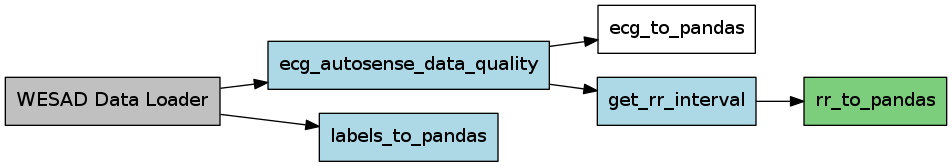

In [ ]:
#Define data set properties
Fs         = 700
sensor     = "respiban"

#Define Workflow
dsd        = wesad_data_loader(data_size="all")
dfl        = cc_to_pandas(dsd,name="labels_to_pandas",key="labels",participant_field="user",datetime_field="timestamp",cache_filename="wesad_labels.pkl")
dsd        = ccwrapper(ecg_autosense_data_quality, dsd, sort_field="timestamp", sensor_name=sensor, Fs=Fs)
df_ecg     = cc_to_pandas(dsd,name="ecg_to_pandas",participant_field="user",datetime_field="timestamp",cache_filename="wesad_ecg.pkl")
dsd        = ccwrapper(get_rr_interval,dsd, sort_field="timestamp",Fs=Fs)
df_rr      = cc_to_pandas(dsd,name="rr_to_pandas",participant_field="user",datetime_field="timestamp",cache_filename="wesad_rr.pkl")

#Execute workflow
flow       = workflow({"ecg":df_ecg,"rr":df_rr,"labels":dfl});
output     = flow.run(backend="sequential", monitor=True, from_scratch=True);


## Display the experimental results

In [17]:
display(output["results"]["report"])

,accuracy_score,f1_score,precision_score,recall_score
Majority,0.786585,0.000000,0.000000,0.000000
LR-CV,0.878049,0.600000,1.000000,0.428571
Tree(D=5),0.859756,0.622951,0.730769,0.542857
SVM(C=1),0.890244,0.653846,1.000000,0.485714


## Display the data yield analysis

In [15]:
display(output['yield']["report"])

,#Individuals,#Individuals with Data,#Instances,#Labeled Instances,%Labeled Instances,#Features,#Observed Feature Values,%Observed Feature Values
WESAD All,15,15,826,826,100.0,11,9086,100.0


## Display the dataset

In [16]:
output["data"]["dataframe"].describe()

,hf,median,iqr,mean,heartrate,80th,20th,lf,vlf,lfhf,var,target
count,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000
mean,-0.063501,0.009630,0.200581,-0.011564,0.169399,-0.023028,0.009332,-0.028304,0.151666,0.166034,0.292850,0.219128
std,0.652313,0.824949,0.918948,0.831679,0.975955,0.871646,0.794589,0.636274,0.624108,0.770858,1.039018,0.413906
min,-1.865354,-2.013441,-1.373961,-2.101279,-1.555548,-2.205813,-1.909198,-1.426320,-0.529125,-0.880678,-0.825620,0.000000
25%,-0.497961,-0.480306,-0.414120,-0.503111,-0.490294,-0.536540,-0.471782,-0.519980,-0.419098,-0.412712,-0.363205,0.000000
50%,0.022083,0.005767,-0.027696,0.006911,-0.005733,0.003729,0.021215,-0.022431,-0.021361,-0.021254,-0.042000,0.000000
75%,0.460691,0.556197,0.574795,0.518320,0.538411,0.510815,0.492153,0.452399,0.567214,0.532512,0.600167,0.000000
max,1.066645,2.455328,4.587269,2.299406,3.773092,2.495151,2.175642,1.324598,2.235011,3.618772,7.191980,1.000000
